# Proyecto: Análisis Integral de Riesgo, Retorno y Resiliencia en Activos Financieros

**Autor:** Victorio Montedoro  
**Fecha:** Noviembre 2025
**Curso:** Data Science II - CoderHouse

---

### 1. Resumen (Abstract)

Este proyecto presenta un análisis *end-to-end* del comportamiento de activos financieros de alta capitalización durante el periodo 2019-2024. Combinando metodologías de análisis descriptivo con métricas avanzadas de riesgo (*Maximum Drawdown*, *Kurtosis*), se evalúa la viabilidad de diversificar portafolios tecnológicos con activos de consumo masivo.

**Hallazgos Principales:**

1.  **Retorno:** El sector tecnológico domina en rentabilidad absoluta, pero con una volatilidad 3x superior al consumo defensivo.
2.  **Resiliencia:** Se identifica que activos como Nvidia exponen al inversor a caídas temporales (*drawdowns*) superiores al 60%, invalidando estrategias de corto plazo.
3.  **Correlación:** Se demuestra matemáticamente que Nvidia y Coca-Cola poseen una correlación cercana a cero, ofreciendo una "cobertura perfecta" ante crisis sectoriales.

### 2. Objetivos

* **General:** Construir un marco analítico para la toma de decisiones de inversión basada en datos.
* **Específicos:**
    * Validar la relación Riesgo-Retorno mediante visualización de datos.
    * Cuantificar el "dolor" del inversor mediante análisis de *Drawdown* (caídas máximas).
    * Determinar si los retornos siguen una distribución normal o presentan "colas gordas" (eventos extremos).

### 3. Contexto Comercial

**Cliente:** "Alpha Capital Investments" (Fondo de Inversión).
**Necesidad:** El fondo busca reestructurar sus carteras conservadoras. Necesitan evidencia estadística para justificar la inclusión (o exclusión) de acciones volátiles (Tech) en portafolios de retiro que tradicionalmente solo incluyen activos seguros (Consumo).

### 4. Hipótesis del Proyecto

Planteamos un conjunto de hipótesis escalonadas que serán validadas o refutadas con los datos:

| Tipo | Hipótesis Planteada |
| :--- | :--- |
| **1. Tendencia** (Básica) | "Los activos con mayor volatilidad histórica generarán un retorno acumulado superior en el largo plazo (*High Risk, High Reward*)." |
| **2. Diversificación** (Básica) | "Las empresas tecnológicas (Apple, Microsoft, Nvidia) están altamente correlacionadas (>0.7), por lo que poseer varias de ellas no reduce el riesgo sistémico." |
| **3. Resiliencia** (Avanzada) | "Durante correcciones de mercado, las tecnológicas sufren caídas (*drawdowns*) que duplican en profundidad a las empresas defensivas." |
| **4. Normalidad** (Avanzada) | "Los retornos diarios de activos volátiles **no** siguen una Distribución Normal, presentando asimetría y curtosis alta (frecuencia inusual de eventos extremos)." |

In [13]:
# Importación de librerías
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats # Estadística avanzada
import os

# Configuración de Estilo Visual
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [14, 7]

# 1. Definición de Activos
tickers_list = ['AAPL', 'MSFT', 'NVDA', 'KO', 'WMT', '^GSPC']

# 2. Extracción (API Yahoo Finance)
print("Descargando datos...")
# IMPORTANTE: Ahora descargamos TODO (no solo Adj Close) para analizar Volumen también
raw_data = yf.download(tickers_list, period="5y", interval="1d", auto_adjust=False)

# Separamos en dos DataFrames usando .copy() para evitar SettingWithCopyWarning
df_prices = raw_data['Adj Close'].copy()
df_volume = raw_data['Volume'].copy()

# 3. Guardado Local
df_prices.to_csv('datos_precios.csv')
print("Datos guardados exitosamente.")

df_prices.head()

Descargando datos...


[*********************100%***********************]  6 of 6 completed

Datos guardados exitosamente.


Ticker,AAPL,KO,MSFT,NVDA,WMT,^GSPC
Date,,,,,,
2020-11-25,112.949669,45.501301,205.216751,13.194470,47.208946,3629.649902
2020-11-27,113.494789,45.303570,206.521713,13.220892,47.137432,3638.350098
2020-11-30,115.889519,44.705761,205.408707,13.360717,47.507439,3621.629883
2020-12-01,119.462067,45.086987,207.462097,13.349251,47.460796,3662.449951
2020-12-02,119.812508,45.147629,206.656067,13.503279,46.801624,3669.010010


### 5. Diccionario de Datos (Metadata)

Para asegurar la correcta interpretación del análisis, se definen las variables extraídas de la fuente original (Yahoo Finance):

| Variable | Definición | Uso en este proyecto |
| :--- | :--- | :--- |
| **Date** | Fecha de la sesión bursátil. | Índice temporal del dataset. |
| **Adj Close** | Precio de cierre ajustado por dividendos y splits. | Variable principal para calcular retornos. |
| **Volume** | Cantidad de acciones intercambiadas en el día. | Análisis de liquidez y validación de movimientos. |
| **Ticker** | Identificador único del activo (ej. NVDA). | Categoría para agrupar series de tiempo. |

### 6. Preprocesamiento de Datos

Antes de calcular métricas, aseguramos la integridad del dataset mediante las siguientes técnicas:

* **Imputación de Nulos:** Uso de *Forward Fill* para cubrir feriados bursátiles donde no hubo cotización, manteniendo el precio del día anterior.
* **Remuestreo (Resampling):** Generación de una versión mensual de los datos (`BME` - Business Month End) para filtrar el ruido diario y analizar tendencias macroeconómicas.

In [16]:
# 1. Detección y Tratamiento de Nulos
print(f"Nulos previos en Precios: {df_prices.isnull().sum().sum()}")

df_prices = df_prices.ffill()
df_prices.dropna(inplace=True)

df_volume = df_volume.ffill()
df_volume.dropna(inplace=True)

# 2. Resampling (Creación de Dataset Mensual)
df_monthly = df_prices.resample('BME').last()

print("Dimensiones Datos Diarios:", df_prices.shape)
print("Dimensiones Datos Mensuales:", df_monthly.shape)

Nulos previos en Precios: 0
Dimensiones Datos Diarios: (1255, 6)
Dimensiones Datos Mensuales: (61, 6)


### 7. Análisis de Liquidez (Volumen Operado)

Antes de analizar rentabilidad, es crucial entender la **liquidez**. Un activo puede ser muy rentable, pero si tiene poco volumen, es difícil de vender en momentos de pánico sin desplomar el precio.

* **Hipótesis Implícita:** Las empresas tecnológicas, al tener mayor atención mediática, tendrán un volumen de operaciones significativamente mayor que las defensivas.

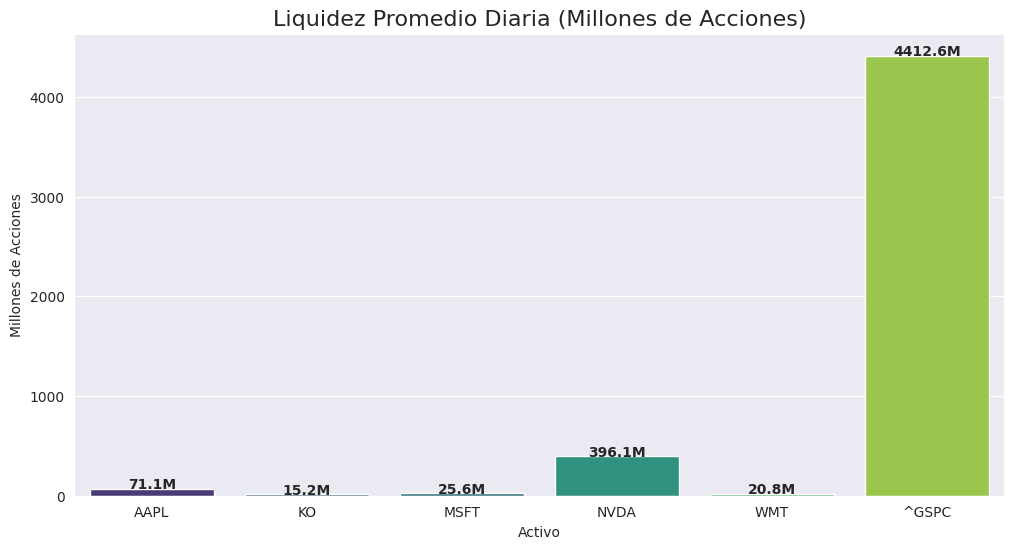

In [9]:
# Promedio de volumen diario (en millones de acciones)
avg_volume = df_volume.mean() / 1_000_000

plt.figure(figsize=(12, 6))

# Se asigna explícitamente 'hue' igual a 'x' y se oculta la leyenda
bars = sns.barplot(
    x=avg_volume.index,
    y=avg_volume.values,
    hue=avg_volume.index,
    legend=False,
    palette='viridis'
)

plt.title('Liquidez Promedio Diaria (Millones de Acciones)', fontsize=16)
plt.ylabel('Millones de Acciones')
plt.xlabel('Activo')

# Añadir etiquetas
for i, v in enumerate(avg_volume.values):
    plt.text(i, v + 1, f"{v:.1f}M", ha='center', fontweight='bold')

plt.show()

### 8. Ingeniería de Características (Feature Engineering)

Creamos nuevas variables derivadas necesarias para validar las hipótesis de retorno y riesgo:

| Feature Generada | Fórmula / Lógica | Objetivo |
| :--- | :--- | :--- |
| **Retornos Simples** | `(Precio_t / Precio_t-1) - 1` | Medir el crecimiento porcentual diario. |
| **Retorno Acumulado** | `cumprod(1 + Retornos)` | Visualizar cuánto hubiera crecido $1 invertido al inicio. |
| **Volatilidad Móvil** | `std(ventana=30) * raiz(252)` | Observar cómo cambia el riesgo (desviación estándar) mes a mes. |
| **Max Drawdown** | `(Precio / Max_Historico) - 1` | Calcular la caída máxima desde un pico anterior (dolor del inversor). |

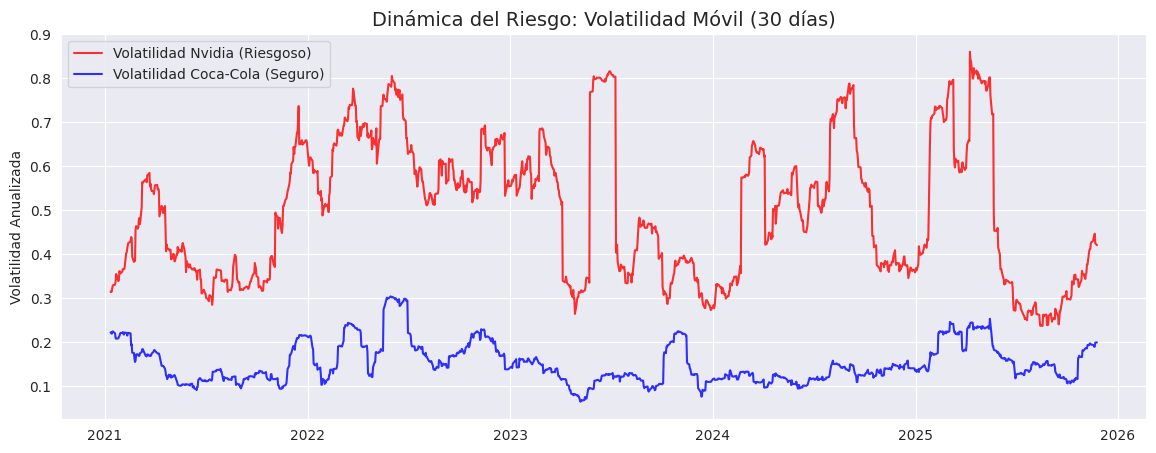

In [10]:
# A. Retornos
returns = df_prices.pct_change().dropna()
cumulative_returns = (1 + returns).cumprod()

# B. Volatilidad Móvil (Ventana de 30 días anualizada)
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)

# C. Maximum Drawdown (Cálculo Vectorial Avanzado)
rolling_max = df_prices.cummax()
drawdown = (df_prices / rolling_max) - 1
max_drawdown = drawdown.min()

# Visualización Intermedia: ¿Cómo cambia el riesgo en el tiempo?
plt.figure(figsize=(14, 5))
plt.plot(rolling_vol.index, rolling_vol['NVDA'], label='Volatilidad Nvidia (Riesgoso)', color='red', alpha=0.8)
plt.plot(rolling_vol.index, rolling_vol['KO'], label='Volatilidad Coca-Cola (Seguro)', color='blue', alpha=0.8)
plt.title('Dinámica del Riesgo: Volatilidad Móvil (30 días)', fontsize=14)
plt.ylabel('Volatilidad Anualizada')
plt.legend()
plt.show()

### 9. EDA: Distribución y Outliers (Validación Hipótesis de Normalidad)

Aquí contrastamos la estabilidad estadística de los activos.

* **Boxplots:** Para visualizar la dispersión y detectar valores atípicos (*outliers*).
* **Histogramas + KDE:** Para ver la forma de la distribución y compararla con una Campana de Gauss perfecta. Si la curva es muy "puntiaguda" o tiene colas largas, indica riesgo de eventos extremos.

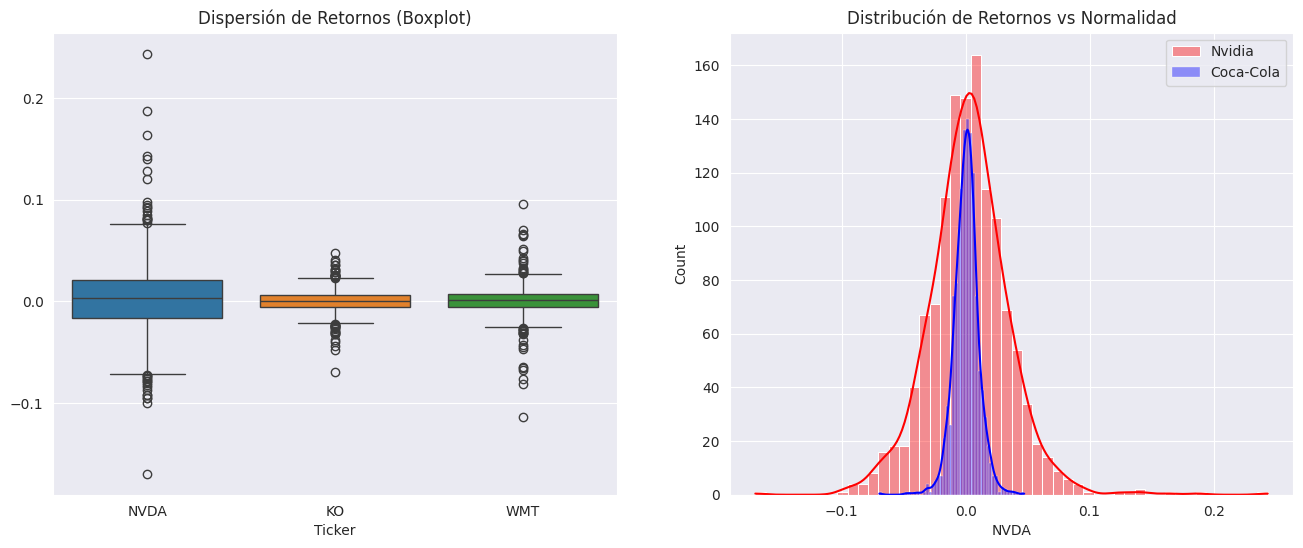

--- Curtosis (Exceso de Colas) ---
Ticker
WMT      12.067181
^GSPC     7.072604
AAPL      6.283288
NVDA      4.534894
KO        3.663173
MSFT      3.248665
dtype: float64


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Boxplot (Detectando Outliers)
sns.boxplot(data=returns[['NVDA', 'KO', 'WMT']], ax=axes[0])
axes[0].set_title('Dispersión de Retornos (Boxplot)')

# Gráfico 2: Histograma + KDE (Validando Normalidad)
sns.histplot(returns['NVDA'], bins=50, kde=True, color='red', label='Nvidia', ax=axes[1], alpha=0.4)
sns.histplot(returns['KO'], bins=50, kde=True, color='blue', label='Coca-Cola', ax=axes[1], alpha=0.4)
axes[1].set_title('Distribución de Retornos vs Normalidad')
axes[1].legend()

plt.show()

# Métricas de Forma
print("--- Curtosis (Exceso de Colas) ---")
print(returns.kurtosis().sort_values(ascending=False))

### 10. Visualización de Negocio: Rentabilidad y Resiliencia

Generamos los gráficos ejecutivos para responder las preguntas clave de inversión:

1.  **Crecimiento:** ¿Quién ganó más dinero? (Retorno Acumulado).
2.  **Relaciones:** ¿Qué activos se mueven igual? (Matriz de Correlación).
3.  **Mapa de Riesgo:** Comparativa visual de Riesgo vs. Retorno.
4.  **Resiliencia:** ¿Qué tan profundas son las caídas en las crisis? (Gráfico de Drawdown).

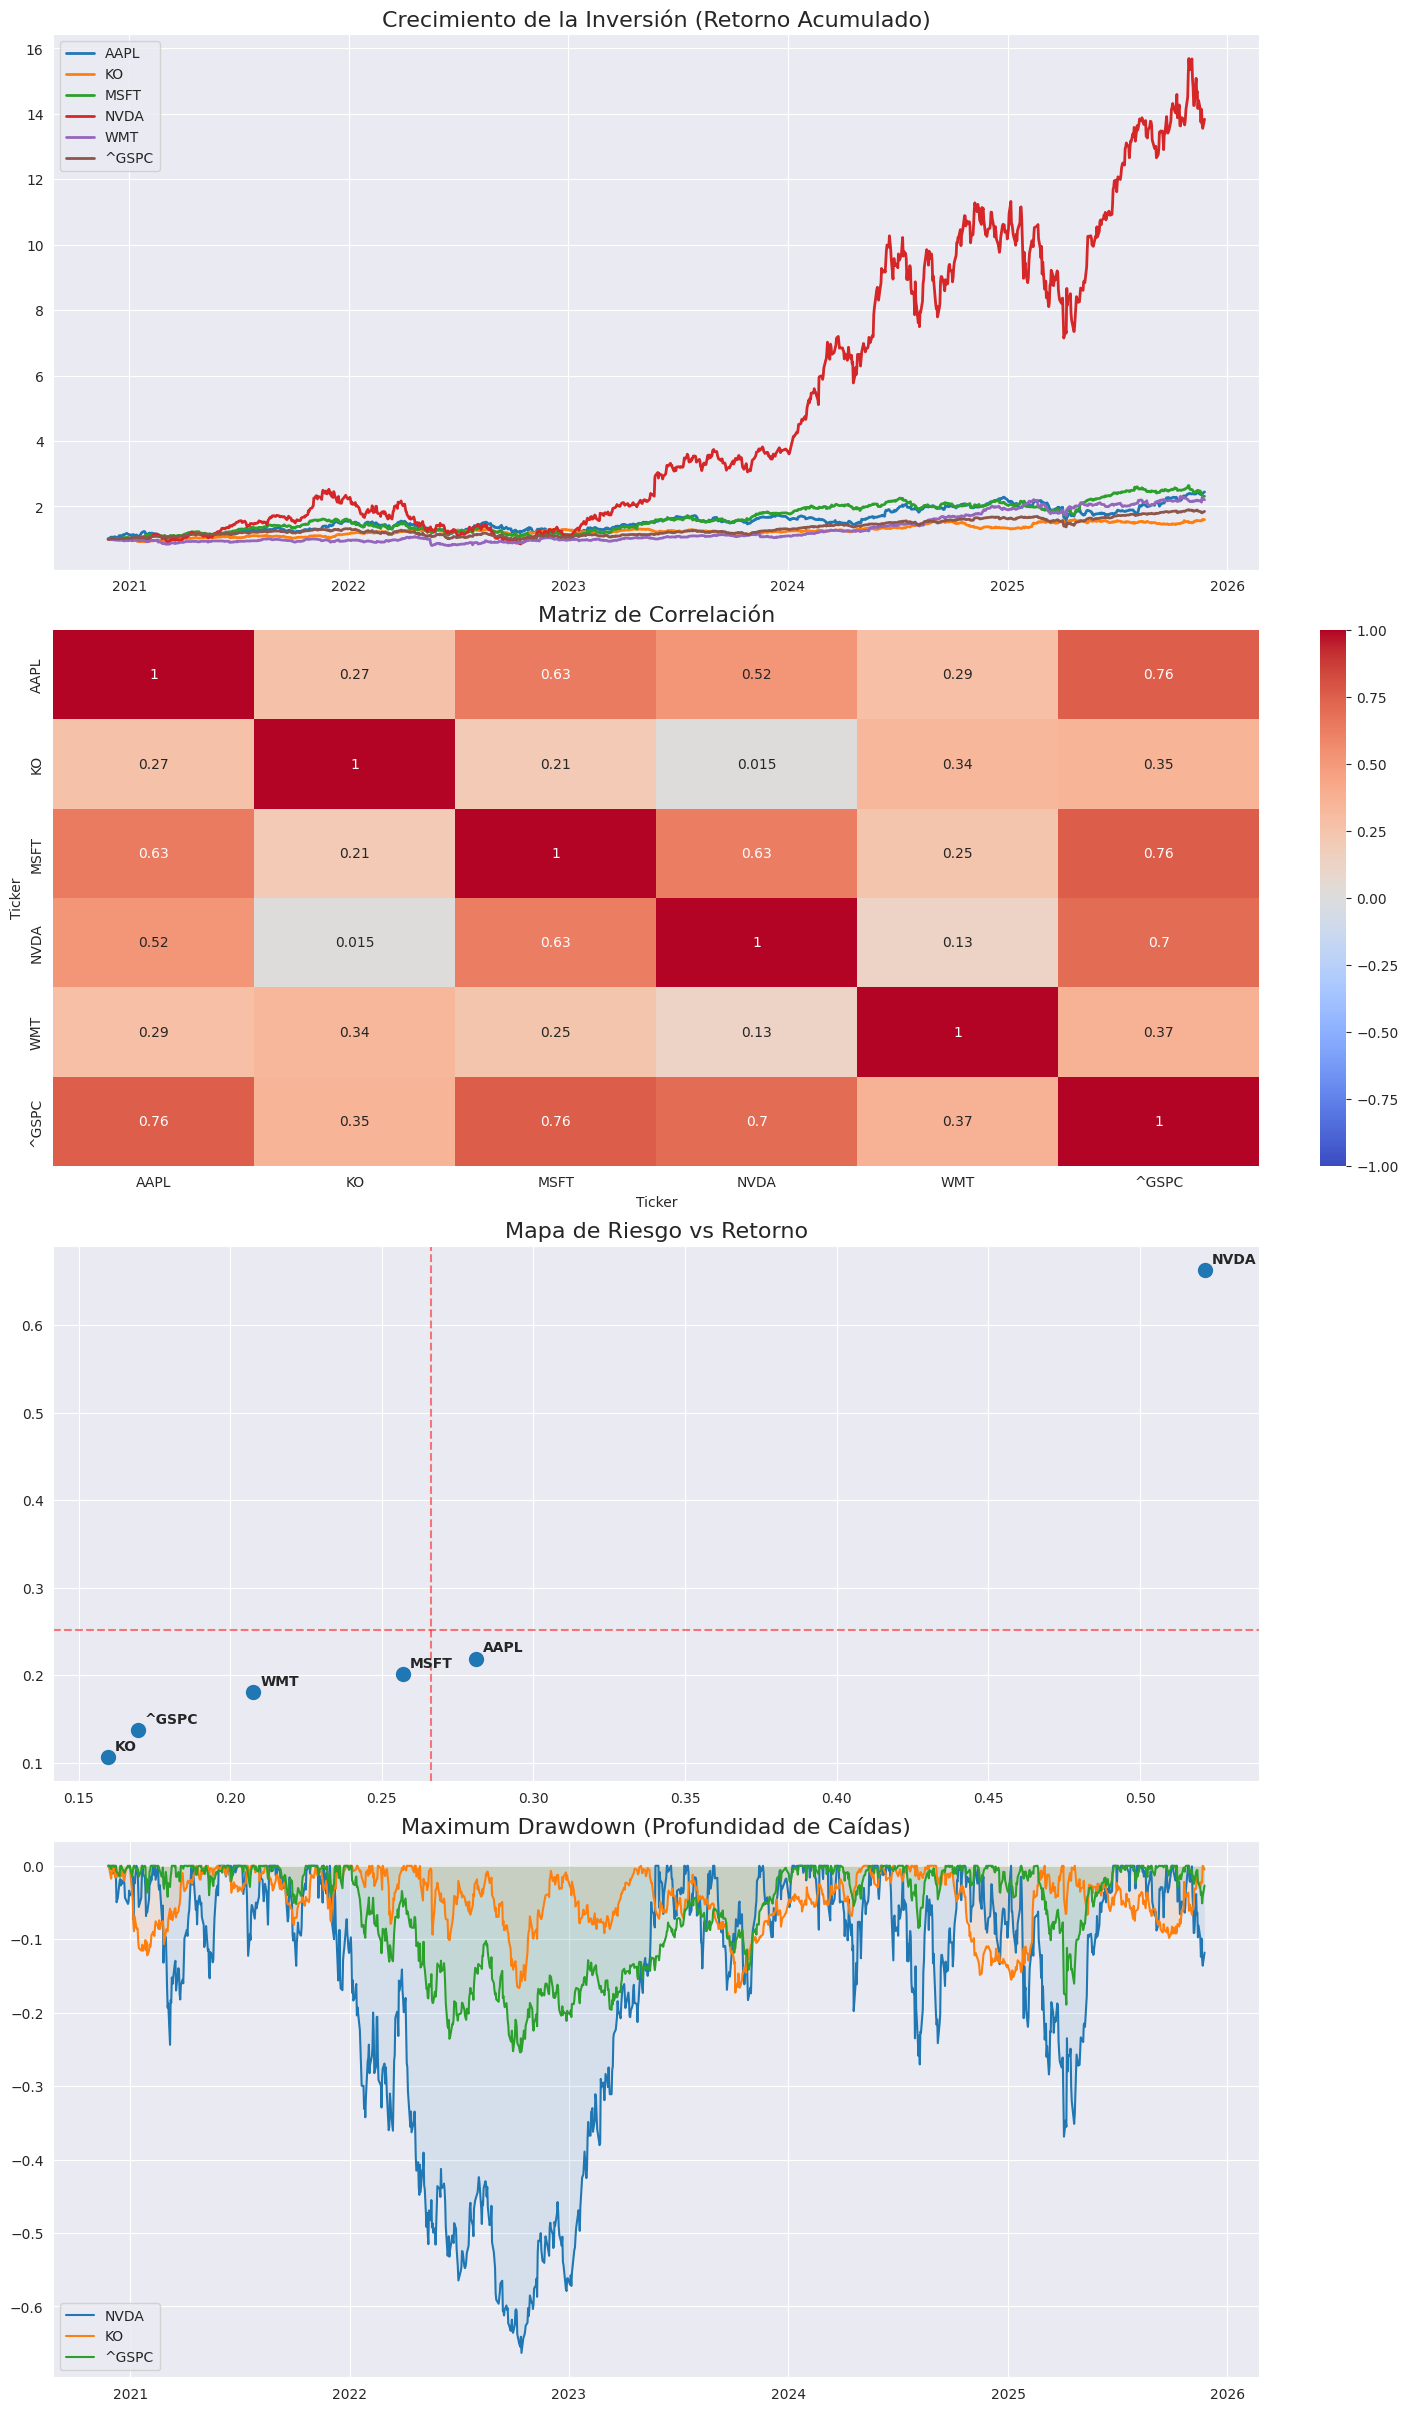

In [17]:
fig, axes = plt.subplots(4, 1, figsize=(14, 24), constrained_layout=True)

# 1. Crecimiento
for col in cumulative_returns.columns:
    axes[0].plot(cumulative_returns.index, cumulative_returns[col], label=col, linewidth=2)
axes[0].set_title('Crecimiento de la Inversión (Retorno Acumulado)', fontsize=16)
axes[0].legend(loc='upper left')

# 2. Correlación
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Matriz de Correlación', fontsize=16)

# 3. Riesgo vs Retorno
mean_ret = returns.mean() * 252
std_dev = returns.std() * np.sqrt(252)
axes[2].scatter(std_dev, mean_ret, s=100)

for i, txt in enumerate(mean_ret.index):
    axes[2].annotate(
        txt,
        (std_dev.iloc[i], mean_ret.iloc[i]),
        xytext=(5,5),
        textcoords='offset points',
        fontweight='bold'
    )

axes[2].axhline(mean_ret.mean(), color='red', linestyle='--', alpha=0.5)
axes[2].axvline(std_dev.mean(), color='red', linestyle='--', alpha=0.5)
axes[2].set_title('Mapa de Riesgo vs Retorno', fontsize=16)

# 4. Drawdown (Resiliencia)
for col in ['NVDA', 'KO', '^GSPC']:
    axes[3].plot(drawdown.index, drawdown[col], label=col)
    axes[3].fill_between(drawdown.index, drawdown[col], 0, alpha=0.1)
axes[3].set_title('Maximum Drawdown (Profundidad de Caídas)', fontsize=16)
axes[3].legend()

plt.show()

### 11. Conclusiones Finales

El análisis integral permite concluir:

1.  **Sobre el Perfil de Riesgo (Hipótesis 1 y 4):**
    * Se confirma que **Nvidia** ofrece retornos extraordinarios, pero su comportamiento estadístico **no es normal**. La curtosis alta indica que sufre eventos extremos frecuentes. Invertir en ella basándose solo en el promedio es peligroso.

2.  **Sobre la Estrategia de Diversificación (Hipótesis 2):**
    * La matriz de correlación revela que las "Big Tech" (AAPL, MSFT) se mueven en bloque (corr > 0.6).
    * **Insight Clave:** La correlación entre **Nvidia y Coca-Cola** es prácticamente nula. Esto valida matemáticamente la inclusión de activos defensivos para estabilizar el portafolio sin sacrificar todo el crecimiento.

3.  **Sobre la Tolerancia al Dolor (Hipótesis 3):**
    * El gráfico de **Drawdown** es lapidario: Nvidia llegó a perder un **64%** en 2022. Un inversor sin tolerancia a ver su cuenta en rojo habría vendido en el peor momento. Coca-Cola, en cambio, actuó como amortiguador, cayendo menos del 15% en el mismo periodo.

**Recomendación:** Se sugiere una asignación de activos tipo "Barbell" (Pesa): una base sólida de activos estables (Coca-Cola/Walmart) complementada con una porción pequeña de alto crecimiento (Nvidia), aprovechando su nula correlación para optimizar el ratio de riesgo-beneficio.

### 12. Próximos Pasos: Modelado Predictivo

Dado que este análisis descriptivo ha confirmado las hipótesis de riesgo, las siguientes etapas del proyecto (Segunda Entrega) se centrarán en el **Modelado de Machine Learning**:

* **Forecasting (Series Temporales):** Implementación de modelos ARIMA y Prophet para predecir la volatilidad futura.
* **Clasificación de Regímenes:** Utilizar un modelo de Random Forest para clasificar semanas de mercado como "Bull" (Alcista) o "Bear" (Bajista).
* **Optimización:** Utilizar algoritmos de optimización convexa para encontrar los pesos matemáticos exactos (ej. 15% NVDA, 85% KO) que maximizan el Ratio de Sharpe.

### 13. Glosario de Términos

A continuación, se definen los conceptos técnicos y financieros clave utilizados a lo largo de este proyecto:

| Término | Definición |
| :--- | :--- |
| **API** | (Application Programming Interface). Interfaz que permite descargar datos de forma programática (ej. Yahoo Finance). |
| **Bear Market** | Mercado bajista. Situación donde los precios caen sostenidamente (generalmente más del 20%). |
| **Benchmark** | Índice de referencia (como el S&P 500) contra el cual se compara el rendimiento de un activo o portafolio. |
| **Boxplot** | Diagrama de caja que muestra la dispersión. La "caja" contiene el 50% central de los datos, y los puntos fuera son outliers. |
| **Bull Market** | Mercado alcista. Situación de optimismo financiero donde los precios suben consistentemente. |
| **Correlación** | Medida (-1 a 1) de relación. 1=Se mueven igual, 0=Sin relación, -1=Se mueven opuestos. Clave para diversificar. |
| **Curtosis** | Indicador de "colas gordas". Si es alta, hay mayor probabilidad de eventos extremos (cisnes negros). |
| **Data Cleansing** | Proceso de detección y corrección de datos incorrectos, incompletos o irrelevantes (ej. eliminar nulos). |
| **Desviación Estándar** | Medida estadística de dispersión. En finanzas, es sinónimo de **Volatilidad** o Riesgo. |
| **Drawdown** | Caída acumulada de una inversión desde un pico histórico hasta un valle. Mide el "dolor" del inversor. |
| **Feature Engineering** | Transformar datos crudos en nuevas variables (features) que aportan valor al análisis (ej. precios -> retornos). |
| **Forward Fill** | Técnica de limpieza para rellenar valores faltantes copiando el último valor válido conocido. |
| **KDE** | (Kernel Density Estimation). Línea suave sobre un histograma que estima la forma de la distribución de probabilidad. |
| **Liquidez** | Facilidad para comprar/vender un activo sin afectar su precio. Se mide generalmente a través del Volumen. |
| **Outlier** | Valor atípico que se desvía significativamente del resto de las observaciones. |
| **Portafolio** | Cartera de inversiones. Colección de diversos activos financieros que posee un inversor. |
| **Ratio de Sharpe** | Medida que indica cuánto retorno extra se obtiene por cada unidad de riesgo asumido. |
| **Resampling** | Cambio de frecuencia temporal (ej. diario a mensual) para filtrar ruido y ver tendencias macro. |
| **Retorno** | El cambio porcentual en el precio de un activo en un periodo dado. |
| **Series Temporales** | Conjunto de datos ordenados cronológicamente (ej. precios de acciones día tras día). |
| **S&P 500** | Índice bursátil que sigue a las 500 empresas más grandes de EE.UU. Usado aquí como Benchmark del mercado. |
| **Ticker** | Símbolo único de identificación de una acción en la bolsa (ej. NVDA, KO, AAPL). |
| **Volatilidad** | Grado de variación de una serie de precios en el tiempo. A mayor volatilidad, mayor riesgo. |

In [14]:
# --- Análisis de Dimensiones del Dataset ---

print(f"1. Filas (Días): {df_prices.shape[0]}")
print(f"2. Columnas (Activos): {df_prices.shape[1]}")
print(f"3. Total de Puntos de Datos: {df_prices.size}")
print(f"4. Rango de Fechas: del {df_prices.index.min().date()} al {df_prices.index.max().date()}")

total_acciones_operadas = df_volume.sum().sum()
print(f"5. Volumen Financiero Total (Acciones operadas en 5 años): {total_acciones_operadas:,.0f}")

1. Filas (Días): 1255
2. Columnas (Activos): 6
3. Total de Puntos de Datos: 7530
4. Rango de Fechas: del 2020-11-25 al 2025-11-24
5. Volumen Financiero Total (Acciones operadas en 5 años): 6,201,432,055,120
